# 1. ライブラリ

In [1]:
# ライブラリ
%matplotlib inline
import warnings
import cv2 # 画像処理に必要
import numpy as np # 数値計算に必要
from IPython.display import Image, display # Notebook上に画像を表示するための関数
from ipywidgets import widgets, interactive, VBox, Output # 閾値を手動で変換し、表示するための関数
import matplotlib.pyplot as plt # グラフ出力で必要
import japanize_matplotlib # 日本語対応
from mpl_toolkits.mplot3d import Axes3D # 3次元プロットで必要
from scipy.ndimage import map_coordinates # 各角度で対応するピクセルが存在しない場合、最も近いピクセルからスペクトル強度を補完
from scipy.optimize import minimize # 楕円関数のfitting(最小二乗法)で必要
from decimal import Decimal, ROUND_HALF_UP # 四捨五入で必要
# from google.colab import drive # colab用
# drive.mount('/content/drive') # colab用
warnings.simplefilter("ignore") # 警告を非表示する

# 2.  動的二値化
> * thresh: 二値化する際の閾値
> * type: 閾値を超えたor超えなかった場合、輝度値をどう処理するかを選択
> * auto: 閾値を手動（None）で選択するか、自動（大津法もしくはトライアングルアルゴリズム）で決定するかを選択
> * 閾値を自分で自由に決めたい場合、**autoをNoneにしていないとthreshのスライダーが動かない**ので注意！

In [2]:
# 画像をグレースケールで読み込み
img = cv2.imread('../../木目.jpg', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('/content/drive/MyDrive/aaa.png', cv2.IMREAD_GRAYSCALE) # colab用

# img = img[:-60, :] # SEMのスケールバー部分を切り取る
binary_image = None # 初期状態の保存画像

# 画像をNotebook上に表示するための関数
def imshow(img):
    encoded = cv2.imencode(".png", img)[1]
    display(Image(encoded))

# 2値化を行う関数
def process(thresh, type_, auto):
    global  binary_image # ウィジェットを更新するためにグローバル変数として参照
    type_ = eval(type_) # 輝度値をどう変換するか（プルダウンメニューから選択）
    auto = eval(auto)  # 閾値を求める方法
    
    # 自動で閾値を求めた際、スライダーの値を更新
    if auto != None:
        type_ += auto
        # 大津法やTriangle法で自動決定された閾値を取得
        ret, binary = cv2.threshold(img, 0, maxval=255, type=type_)
        # スライダーの閾値を自動設定値に更新
        if param_widgets["thresh"].value != int(ret):
            param_widgets["thresh"].value = int(ret)
            return  # スライダーの更新時に再描画されるので表示処理を終了（これないと画像が2枚出力されてしまう）
    else:
        # 自動閾値が使われない場合、スライダーの設定値をそのまま使用
        ret, binary = cv2.threshold(img, thresh, maxval=255, type=type_)
    
    # 画像を表示
    imshow(binary)
    # 保存用に二値化画像を保持
    binary_image = binary

# 画像を保存するための関数
def save_image(button):
    # ボタンが押されたときに画像を保存
    with output:  # 出力ウィジェットを使ってメッセージを表示
        output.clear_output(wait=True)  # 以前の出力をクリア
        if binary_image is not None:
            # 画像の保存
            """ここで2値化画像の保存先とファイル名を指定して下さい！"""
            cv2.imwrite("../Plot/2値化画像.png", binary_image)
            print("画像が保存されました: 2値化画像.png")
        else:
            print("画像がありません。保存されていません。")
            
# ウィジェット設定
param_widgets = {}

# スライダーの設定
param_widgets["thresh"] = widgets.IntSlider(
    min=0, max=255, step=1, value=100, description="thresh: "
)

# 輝度値をどう変換するか（プルダウンメニューから選択）
param_widgets["type_"] = widgets.Dropdown(
    options=[
        "cv2.THRESH_BINARY", # 画素の輝度値が閾値を超える場合は255（白）、そうでない場合は0(黒)に設定
        "cv2.THRESH_BINARY_INV", # 画素の輝度値が閾値を超える場合は0(黒)、そうでない場合は255(黒)に設定
        "cv2.THRESH_TRUNC", # 画素の輝度値が閾値を超える場合は閾値に、そうでない場合はそのままの値に設定
        "cv2.THRESH_TOZERO", # 画素の輝度値が閾値を超える場合はそのままの値に、そうでない場合は0(黒)に設定
        "cv2.THRESH_TOZERO_INV", # 画素の輝度値が閾値を超える場合は0(黒)に、そうでない場合はそのままの値に設定
    ],
    description="type: "
)

# 閾値を求める方法を選択
param_widgets["auto"] = widgets.Dropdown(
    options=[
        "None", # 手動で閾値を選択
        "cv2.THRESH_OTSU", # 大津法により自動的に閾値を決定
        "cv2.THRESH_TRIANGLE" # トライアングルアルゴリズムにより自動的に閾値を決定
    ],
    description="auto: "
)

# 保存ボタンの設定
save_button = widgets.Button(description="保存")
save_button.on_click(save_image)  # ボタンがクリックされたときに保存関数を呼び出す

# 出力ウィジェットの設定
output = Output()

# 各ウィジェットの幅を設定
for x in param_widgets.values():
    x.layout.width = "400px"

# インタラクティブウィジェットと保存ボタンを表示
ui = VBox([interactive(process, **param_widgets), save_button, output])
display(ui)

# 3.  画像の切り取り
> * **高速フーリエ変換（FFT、後ほど説明）を行う場合、対象のデータサイズは2の累乗**である必要がある。**SEMの画像は2の累乗ではないので注意！**
> * **配向性を評価する場合は画像の幅と高さが同じ**である必要がある！（同じでないと配向角が実際と異なることがある）

元画像の幅×高さ: 800 × 600ピクセル
切り取り画像の幅×高さ: 512 × 512ピクセル


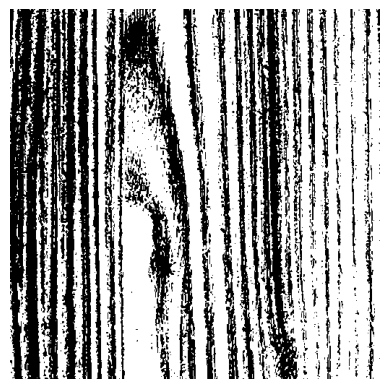

In [3]:
# 画像を読み込む
img = cv2.imread("../Plot/2値化画像.png", cv2.IMREAD_GRAYSCALE)

# 画像のサイズを取得
height, width = img.shape[:2]  # 画像の高さと幅を取得

# 最大の2の累乗サイズを計算する関数
def largest_power_of_two(size):
    return 2 ** int(np.floor(np.log2(size)))

# 短辺のサイズを基準に2の累乗サイズを決定
short_side = min(width, height)
square_size = largest_power_of_two(short_side)  # 短辺の最大の2の累乗サイズ

# 画像の中心を求める
center_x, center_y = width // 2, height // 2  # 画像の中心座標を計算

# 切り取る領域の左上と右下の座標を計算
start_x = center_x - square_size // 2  # 左上のx座標
start_y = center_y - square_size // 2  # 左上のy座標
end_x = start_x + square_size          # 右下のx座標
end_y = start_y + square_size          # 右下のy座標

# 切り取る範囲が画像のサイズを超えないように制約を追加（念のため）
start_x = max(start_x, 0)
start_y = max(start_y, 0)
end_x = min(end_x, width)
end_y = min(end_y, height)

# 画像をカット（クロップ）
cropped_img = img[start_y:end_y, start_x:end_x]  # 計算した座標を使って画像を切り取る

# 画像の大きさを出力
print(f"元画像の幅×高さ: {width} × {height}ピクセル")
print(f"切り取り画像の幅×高さ: {cropped_img.shape[1]} × {cropped_img.shape[0]}ピクセル")

# 切り取り画像を保存
cv2.imwrite("../Plot/切り取り2値化画像.png", cropped_img)

# 画像の表示
plt.imshow(cropped_img, cmap='gray')
plt.axis('off')  # 軸を非表示に
plt.show()


# 4. 画像の2次元フーリエ変換
> # フーリエ変換
> * **フーリエ変換**とは、複雑な関数や現象を三角関数に分解し、周波数成分として解析する方法。
$$F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i \omega t} \, dx$$
ここで$f(t)$は連続関数、$F(\omega)$は周波数領域の関数、$\omega$は角周波数、$i$は虚数単位、$e$はネイピア数である。
<br><br>
> * コンピュータでは扱うデータ（例えば画像）が連続値ではなく離散値であるため、無限個の処理はできない。そのため関数を無限個の周波数の波ではなく、有限個の異なる周波数の波に分解する**離散フーリエ変換**（DFT: Discrete Fourier Transformation）を行う。
> * DFTは任意のデータ並びに内在する周期的な変動（規則性）を「振幅」と「波長」を持つ有限個の三角関数の単調な周期波（cos波、sin波）に分解した合成和で近似していくが、この分解能を利用して、繊維配置に隠れている周期性を見出し、これを繊維配向解析に応用する。
> * なお、DFTでは計算処理をさらに高速化した**高速フーリエ変換**（FFT: Fast Fourier Transformation）を利用することが多い。FFTはDFTと同じ数式ではあるが、**データサイズが2の累乗である**という制約を設け、複数の小さなサブセットにデータを分割、それぞれを独立に計算することで効率化している。

> # 2次元FFT
> * FFTはデータの配列順序が重要であるため、画像のような2次元のデータは**2次元FFT**が使用される。
$$F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot e^{-i 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}$$
ここで$M, y$は画像の高さ（縦のピクセル）、$N, x$は画像の幅（横のピクセル）、$v$は縦方向の周波数インデックス、$u$は横方向の周波数インデックス、$f(x, y)$は$(x, y)$の輝度値、$F(u, v)$は周波数$(u, v)$における周波数成分の強度を表す。
<br><br>
<font color="red">補足:</font> ある$M \times N$の画像と表記されるときは、数学的表現に従い、縦$×$横と判断する。一方、画像処理の分野では、画像を$N \times M$ピクセルと表記するので、どちらが縦横なのかは十分注意する必要がある。
<br><br>
> * 2次元FFTでは、(1)画像の横方向に対して1次元FFT (2)画像の縦方向に対して1次元FFTの流れで周波数成分を抽出する。
<br>
(1)横方向の1次元FFT
$$F(u, y) = \sum_{x=0}^{N-1} f(x, y) e^{-i \frac{2\pi}{N} ux}$$
(2)縦方向の1次元FFT
$$F(u, v) = \sum_{y=0}^{M-1} F(u, y) e^{-i \frac{2\pi}{M} vy}$$
> * **低周波成分**は、画像内の変化が緩やかな部分を指し、画像全体の大まかな形状やぼやけた部分、明るさのグラデーションなどが該当する。
> * **高周波成分**は、画像内の変化が激しい部分を指し、画像のエッジ（輪郭）やテクスチャ（布や木目など）、ノイズなどが該当する。

In [4]:
# 画像を読み込む
img = cv2.imread("../Plot/切り取り2値化画像.png", cv2.IMREAD_GRAYSCALE)  

# 2次元高速フーリエ変換
f_transform = np.fft.fft2(img) 

# 5. シフト操作
> * フーリエ変換を行うと左下の画像が得られる。画像の角の部分（光っている部分）が低周波成分、中心が高周波成分となっている。
> * ここから周波数成分の可視化・解析をしやすくするために、**シフト操作**（右下の画像）を行う必要がある。
> 
> ![フーリエ変換後画像](https://cdn-ak.f.st-hatena.com/images/fotolife/w/werry-chan/20181229/20181229134358.jpg)![シフト操作画像](https://cdn-ak.f.st-hatena.com/images/fotolife/w/werry-chan/20181229/20181229215446.jpg)
> * シフト操作では、格子状に並んだフーリエ変換後データに対して、上下左右に4等分し、下図に示すように1と3、2と4の領域を入れ替える。
> * これにより、低周波成分が画像の中央に配置され、その周囲に高周波成分が配置される。
> 
> ![シフト操作の概要図](https://cdn-ak.f.st-hatena.com/images/fotolife/w/werry-chan/20181229/20181229215844.png)
> 
> [画像引用](https://werry-chann.com/entry/2018/12/29/233554)
<br>
> [参考論文(Fig.6が該当)](https://www.jstage.jst.go.jp/article/jacc/57/0/57_917/_pdf/-char/ja)

In [5]:
# シフト操作
f_transform_shifted = np.fft.fftshift(f_transform)

# 6. パワースペクトル画像の出力
> * フーリエ変換によって得られる値は複素数であり、可視化するには複素数の絶対値（**振幅スペクトル**）の2乗を算出する必要がある。
> * この時求めた振幅スペクトルの2乗を**パワースペクトル**と呼ぶ。
$$P(u, v) = |F(u, v)|^2$$
> * ただしパワースペクトルは通常、非常に大きな値を取るため、可視化する際には値のスケールを縮小する必要がある。一般的には自然対数を取ることが多く、これによりデータの分布が平坦になるとともに、極端な値の影響を軽減することができる。
$$ P_{\text{log}}(u, v) = \log(P(u, v)) = \log(|F(u, v)|^2)$$
ここでパワースペクトルの値が1以下のとき、対数計算を行うと負の無限大に近い値が生じて計算が不安定になるのを防ぐため、$P_{\text{log}}(u, v)\leq1$の場合は$P_{\text{log}}(u, v)=0$とした。

## 6.1. パワースペクトルのスケーリング
> * 左図がスケーリング前のパワースペクトル、右図が自然対数でスケーリングしたパワースペクトルである。
> * パワースペクトルの振幅成分は低周波成分が非常に大きく、高周波成分が小さくなる傾向があるため、直接プロットすると左図のように高周波成分が埋もれてしまう。

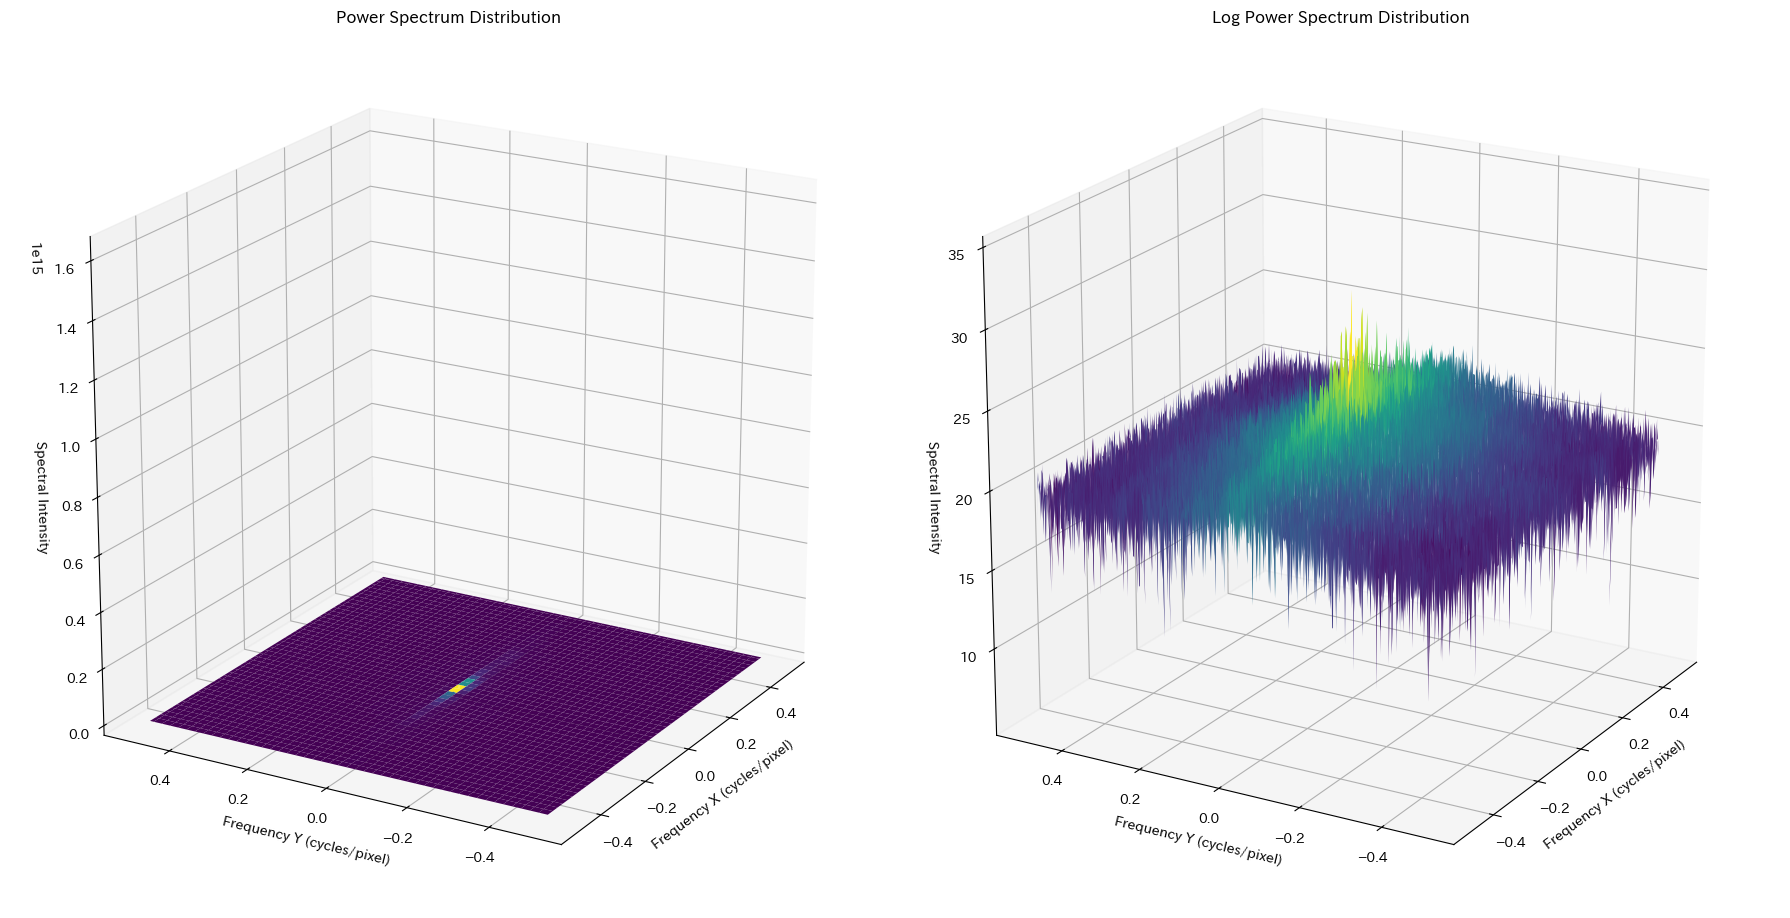

In [6]:
# パワースペクトル
power_spectrum = np.abs(f_transform_shifted) ** 2 # パワースペクトル = 振幅スペクトルの2乗
power_spectrum_log = np.log(np.maximum(power_spectrum, 1)) # スケーリング（ただしパワースペクトル<1の場合、ln(1)=0とする）

# 周波数スケールの取得
rows, cols = img.shape # 画像サイズを取得
freq_y = np.fft.fftshift(np.fft.fftfreq(rows)) # 縦方向
freq_x = np.fft.fftshift(np.fft.fftfreq(cols)) # 横方向

# グリッドを作成
freq_x, freq_y = np.meshgrid(freq_x, freq_y)

# 3Dプロットの表示
plt.figure(figsize=(18, 10))

# パワースペクトルの3Dプロット
ax1 = plt.subplot(1, 2, 1, projection='3d')
ax1.plot_surface(freq_x, freq_y, power_spectrum, cmap='viridis')
ax1.view_init(elev=20, azim=210)  # 視点の高さと方位を設定
ax1.set_title('Power Spectrum Distribution')
ax1.set_xlabel('Frequency X (cycles/pixel)')
ax1.set_ylabel('Frequency Y (cycles/pixel)')
ax1.set_zlabel('Spectral Intensity')

# パワースペクトル（対数処理後）の3Dプロット
ax2 = plt.subplot(1, 2, 2, projection='3d')
ax2.plot_surface(freq_x, freq_y, power_spectrum_log, cmap='viridis')
ax2.view_init(elev=20, azim=210)  # 視点の高さと方位を設定
ax2.set_title('Log Power Spectrum Distribution')
ax2.set_xlabel('Frequency X (cycles/pixel)')
ax2.set_ylabel('Frequency Y (cycles/pixel)')
ax2.set_zlabel('Spectral Intensity')

# アスペクト比を設定
ax1.set_box_aspect([1, 1, 1])  # X, Y, Zのアスペクト比を1:1:1に設定
ax2.set_box_aspect([1, 1, 1])  # X, Y, Zのアスペクト比を1:1:1に設定

plt.tight_layout()  # レイアウトの最適化
# plt.savefig("../Plot/Power Spectrum Distribution with Frequency Scale.png", bbox_inches='tight')
plt.show()

## 6.2. シフト操作の確認（復習）
> * シフト操作によって低周波成分が中央に、高周波成分がその周囲に配置されていることを確認する。
> * 復讐も兼ねて画像の読み込みから改めて実装している。
> * 左が元の画像、中央が2次元FFT後のパワースペクトル(対数処理)、右が2次元FFT後にシフト操作を行ったパワースペクトル（対数処理）となっている。
> * 元画像が長方形であるのに対し、パワースペクトル画像が正方形に変換されているのは**軸目盛りを周波数スケール（サイクル/ピクセル、すなわちピクセルごとに繰り返される波の回数）に指定**しているためであり、**周波数成分の範囲は$-0.5$から$0.5$となる**からである。（詳しくは**ナイキスト周波数**と**標本化定理**）
> * つまり中心$(0,0)$は低周波成分を示し、端に行くほど高周波成分に近づくことを意味する。

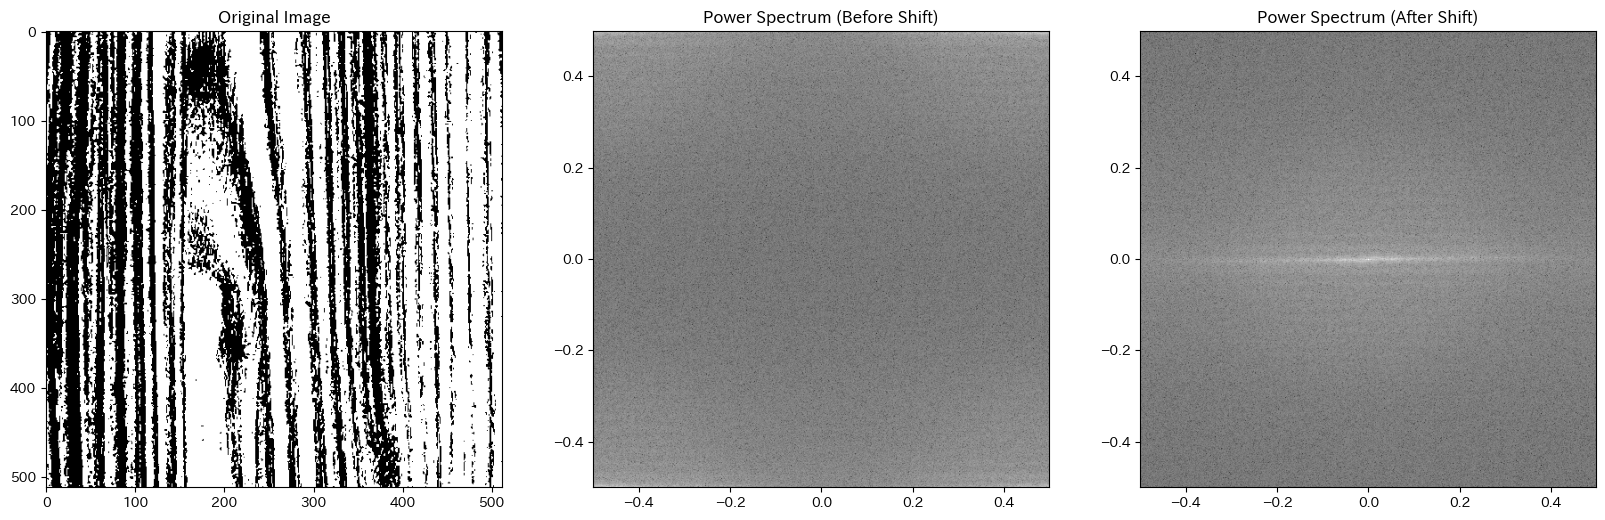

In [7]:
# 画像を読み込む
img = cv2.imread("../Plot/切り取り2値化画像.png", cv2.IMREAD_GRAYSCALE)

# 2次元高速フーリエ変換
f_transform = np.fft.fft2(img)

# シフト操作
f_transform_shifted = np.fft.fftshift(f_transform)

# パワースペクトル = 振幅スペクトルの2乗
power_spectrum_noshift = np.abs(f_transform) ** 2
power_spectrum = np.abs(f_transform_shifted) ** 2

# スケーリング（ただしパワースペクトル<1の場合、ln(1)=0とする）
power_spectrum_noshift_log = np.log(np.maximum(power_spectrum_noshift, 1)) 
power_spectrum_log = np.log(np.maximum(power_spectrum, 1)) 

# 周波数スケールの取得
rows, cols = img.shape
freq_y = np.fft.fftshift(np.fft.fftfreq(rows))
freq_x = np.fft.fftshift(np.fft.fftfreq(cols))

# グリッドを作成
freq_x, freq_y = np.meshgrid(freq_x, freq_y)

# グラフ出力
fig, ax = plt.subplots(1, 3, figsize=(20, 12))

# 元画像
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image')

# シフト操作前のパワースペクトル画像
ax[1].imshow(power_spectrum_noshift_log, cmap='gray', extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()))  # extentで軸目盛りを周波数スケールに指定
ax[1].set_title('Power Spectrum (Before Shift)')

# シフト操作後のパワースペクトル画像
ax[2].imshow(power_spectrum_log, cmap='gray', extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()))  
ax[2].set_title('Power Spectrum (After Shift)')

# 保存
# plt.imsave("../Plot/power_spectrum_before_shift.png", power_spectrum_noshift_log, format='png')
# plt.imsave("../Plot/power_spectrum_after_shift.png", power_spectrum_log, format='png') 
# plt.savefig("../Plot/元画像とシフト操作前後の比較.png", bbox_inches='tight')
plt.show()        

# 7. 逆フーリエ変換による低周波・高周波成分の可視化
> # 周波数フィルタリング
> * フーリエ変換の結果は、画像に含まれるそれぞれの周波数成分を表している。
> * そこで、フーリエ変換後の各周波数成分の大きさを各成分ごとに変えることにより、元の画像の性質を変化させることができる。このような処理を**周波数フィルタリング**という。
$$G(u,v)=F(u,v)H(u,v)$$
ここで$F(u,v)$は元の画像をフーリエ変換したもの、$H(u,v)$は周波数フィルタ、$G(u,v)$は各周波数成分にフィルタを掛け算した結果を表す。
<br><br>
> * 画像に含まれる空間周波数成分のうち、低周波成分は残し、高周波成分は除去するようなフィルタを**ローパスフィルタ**、反対に画像の高周波成分は残し、低周波成分を除去するようなフィルタを**ハイパスフィルタ**と呼ぶ。

> # 逆フーリエ変換
> * **逆フーリエ変換**とは、フーリエ変換された関数を逆に元の関数に戻す操作を指す。
> * 周波数フィルタリングを行った後の$G(u,v)$を画像$g(x,y)$として出力するには、逆フーリエ変換（4.で説明したように、データが離散値であるので、正しく言うと**逆離散フーリエ変換**）が必要である。
$$g(x, y) = \frac{1}{MN} \sum_{u=0}^{M-1} \sum_{v=0}^{N-1} G(u, v) \cdot e^{i 2 \pi \left( \frac{ux}{M} + \frac{vy}{N} \right)}$$
> * 下図より、ローパスフィルタ適用後、逆フーリエ変換したものは画像全体のぼやけた部分、ハイパスフィルタ適用後、逆フーリエ変換したものは画像のエッジを捉えていることが見て取れる。

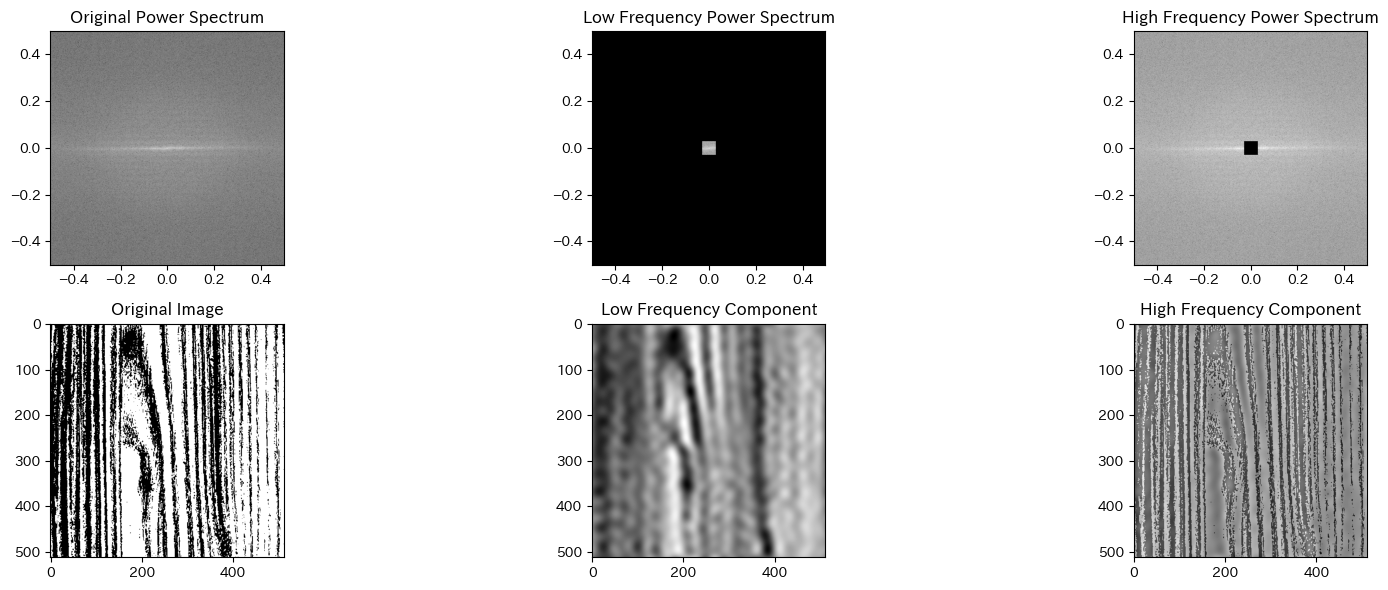

In [8]:
# 画像を読み込む
img = cv2.imread("../Plot/切り取り2値化画像.png", cv2.IMREAD_GRAYSCALE)

# 2次元高速フーリエ変換
f_transform = np.fft.fft2(img)

# シフト操作
f_transform_shifted = np.fft.fftshift(f_transform)

# 周波数スケールの取得
rows, cols = img.shape
crow, ccol = rows // 2 , cols // 2  # 中心座標の取得
freq_y = np.fft.fftshift(np.fft.fftfreq(rows))  # 縦方向
freq_x = np.fft.fftshift(np.fft.fftfreq(cols))  # 横方向

# グリッドを作成
freq_x, freq_y = np.meshgrid(freq_x, freq_y)

# フィルタサイズの設定
low_freq_filter_size = 15  # 低周波成分
high_freq_filter_size = 15  # 高周波成分

# 低周波成分の抽出
low_pass_filter = np.zeros((rows, cols), np.uint8)
low_pass_filter[crow-low_freq_filter_size:crow+low_freq_filter_size, ccol-low_freq_filter_size:ccol+low_freq_filter_size] = 1
low_freq_component = f_transform_shifted * low_pass_filter

# 高周波成分の抽出
high_pass_filter = np.ones((rows, cols), np.uint8)
high_pass_filter[crow-high_freq_filter_size:crow+high_freq_filter_size, ccol-high_freq_filter_size:ccol+high_freq_filter_size] = 0
high_freq_component = f_transform_shifted * high_pass_filter

# パワースペクトル = 振幅スペクトルの2乗
power_spectrum = np.abs(f_transform_shifted) ** 2 # 元画像 
low_freq_power_spectrum = np.abs(low_freq_component) ** 2 # 低周波成分
high_freq_power_spectrum = np.abs(high_freq_component) ** 2 # 高周波成分

# スケーリング（ただしパワースペクトル<1の場合、ln(1)=0とする）
power_spectrum_log = np.log(np.maximum(power_spectrum, 1)) # 元画像
low_freq_power_spectrum_log = np.log(np.maximum(low_freq_power_spectrum, 1)) # 低周波成分
high_freq_power_spectrum_log = np.log(np.maximum(high_freq_power_spectrum, 1)) # 高周波成分

# 逆フーリエ変換
ifft_img = np.fft.ifft2(np.fft.ifftshift(f_transform_shifted)).real # 元画像 
low_ifft_img = np.fft.ifft2(np.fft.ifftshift(low_freq_component)).real # 低周波成分
high_ifft_img = np.fft.ifft2(np.fft.ifftshift(high_freq_component)).real # 高周波成分

# 結果の表示
fig, ax = plt.subplots(2, 3, figsize=(18, 6))

# 自然対数でスケーリングしたパワースペクトル図
ax[0][0].imshow(power_spectrum_log, cmap='gray', extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max())) # 元画像
ax[0][0].set_title("Original Power Spectrum")
ax[0][1].imshow(low_freq_power_spectrum_log, cmap='gray', extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max())) # 低周波成分
ax[0][1].set_title("Low Frequency Power Spectrum")
ax[0][2].imshow(high_freq_power_spectrum_log, cmap='gray', extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max())) # 高周波成分
ax[0][2].set_title("High Frequency Power Spectrum")

# 逆フーリエ変換画像
ax[1][0].imshow(ifft_img, cmap='gray')  # 元画像
ax[1][0].set_title("Original Image")
ax[1][1].imshow(low_ifft_img, cmap='gray')  # 低周波成分
ax[1][1].set_title("Low Frequency Component")
ax[1][2].imshow(high_ifft_img, cmap='gray')  # 高周波成分
ax[1][2].set_title("High Frequency Component")

plt.tight_layout()
# plt.savefig("../Plot/逆フーリエ変換.png", bbox_inches='tight')
plt.show()

# 8. 配向角と配向強度の算出
> * パワースペクトルの中央から各方向（角度）に沿ったスペクトル強度を積算し、その平均値をとったものを**平均スペクトル**と呼ぶ。
> * 平均スペクトルは下記の式で求められる。
$$\text{average\_spectrum}(\theta) = \frac{1}{N(\theta)} \sum_{r=E}^{R_{\text{max}}} P(r, \theta)$$
ここで直交座標系と極座標系の関係を以下に示す。
$$u = r \cos(\theta)$$
$$v = r \sin(\theta)$$
$$r = \sqrt{u^2 + v^2}$$
$$P(r, \theta) = P(u, v) = P(r \cos(\theta), r \sin(\theta))$$
また$\theta$は角度、$r$はパワースペクトル中央からの距離（半径）、$P(r, \theta)$は半径$r$と角度$\theta$におけるパワースペクトルの値、$E$は除外データ数+1、$N(\theta)$は角度方向における積算点の数を表す。<br>
<br><br>
> * パワースペクトルの中央からそれぞれの角度に対する平均スペクトル強度を算出・プロットしたとき、画像に配向性があれば楕円、配向性がなければ円を示す。
> * 楕円であった場合、**短軸は繊維の配向する方向**、**長軸は配向の度合い**を示す。（と文献上では定義されているが、**このコードでは長軸が配向度合いと配向する方向の両方を示しているので注意！！**）
> * 楕円の一般式と長軸($L_{\text{major}}$)、短軸($L_{\text{minor}}$)はそれぞれ以下のように表される。
$$a x^2 + b x y + c y^2 = 1$$
$$L_{\text{major}} = \frac{2}{\sqrt{a + c - \sqrt{(a - c)^2 + b^2}}}$$
$$L_{\text{minor}} = \frac{2}{\sqrt{a + c + \sqrt{(a - c)^2 + b^2}}}$$
> * このとき**繊維の配向強度は近似した楕円の長軸/短軸比**とし、その値の大きさから配向性を以下のように評価する。
| 配向強度 | 評価 |
| ---- | ---- |
| 1.1以下 | 無配向 |
| 1.1〜1.2 | やや配向 |
| 1.2以上 | 強い配向 |
> * また配向角$\theta$（度数表記）を短軸角度とすると、以下の式で求められる。
$$\theta = \left|\frac{180}{\pi} \cdot \frac{1}{2} \arctan\left(\frac{b}{a - c}\right)\right|$$
> * 文献上では上記の式で定義されているが、絶対値がついていると返って解釈しにくい。（配向角が0〜180°の範囲に収まるなら良いが、〜360°までは考えることが出来ない）
> * 配向角$\theta$（度数表記）を下記の式に変更したところ、うまく解析することが出来た。
$$\theta = \frac{180}{\pi} \cdot \frac{1}{2} \arctan\left(\frac{b}{a - c}\right)+90$$

# 解析手法1
> * [参考文献](https://www.jstage.jst.go.jp/article/jacc/57/0/57_917/_pdf/-char/ja)の内容をもとに実装。
> * $\Delta{\theta}=1°$ごとに平均スペクトルを計算する。
> * ローパスフィルタは画像全体の大まかな構造や配置を把握するのに適しているため、**画像を見て明らかに配向性があると判断できる場合に有効**である。
> * ハイパスフィルタは画像のエッジを把握するのに適しているため、**麹菌のように繊維の配向が入り乱れている場合に有効**である。
> * ローパス/ハイパスフィルタの適用は7で実装しているため、ここで事前に有効かどうかを確認しておくと良い。

楕円関数の係数: a = 0.00244, b = 0.00001, c = 0.00208
長軸（楕円の係数から算出）: 21.93189, 長軸（配向角から算出）: 24.03325
短軸（楕円の係数から算出）: 20.24119, 短軸（配向角から算出）: 20.52004
配向強度（楕円の係数から算出）: 1.08353, 配向強度（配向角から算出）: 1.17121
配向角度: 91.094°
配向性評価（楕円の係数）: 無配向です
配向性評価（配向角）: やや配向があります


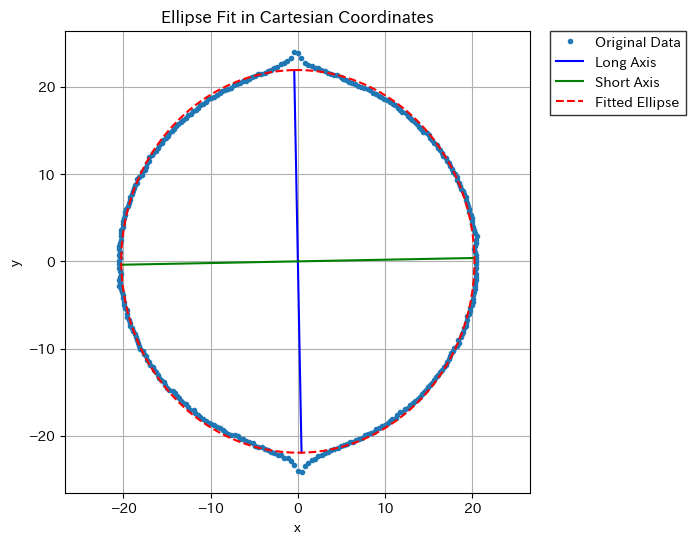

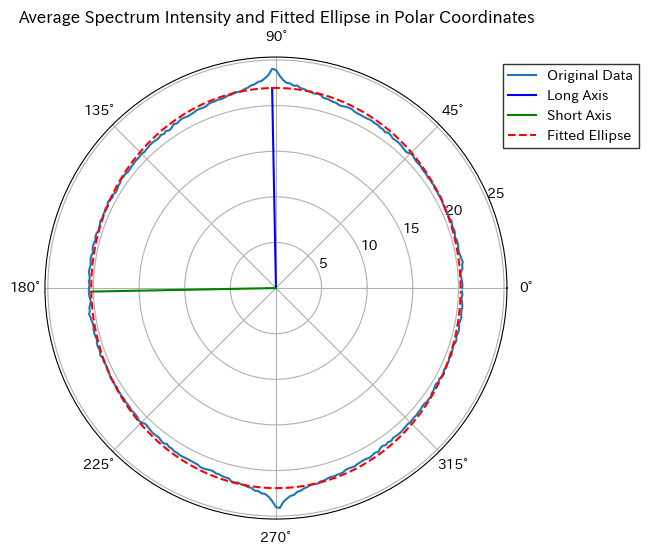

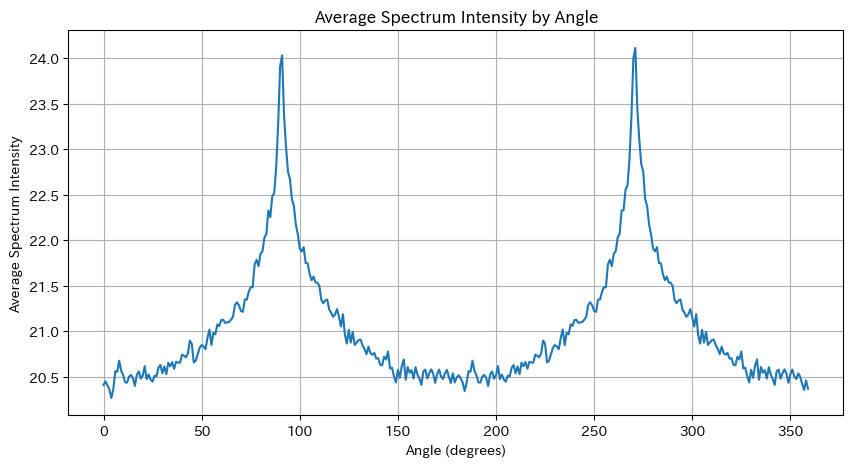

In [9]:
# 画像を読み込む
image_path = "../Plot/切り取り2値化画像.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# 2次元高速フーリエ変換
f_transform = np.fft.fft2(img)

# シフト操作
f_transform_shifted = np.fft.fftshift(f_transform)

# 周波数スケールの取得
rows, cols = img.shape
crow, ccol = rows // 2 , cols // 2  # 中心座標の取得

# フィルタサイズの設定
low_freq_filter_size = 10  # 低周波成分
high_freq_filter_size = 20  # 高周波成分

# 低周波成分の抽出
low_pass_filter = np.zeros((rows, cols), np.uint8)
low_pass_filter[crow-low_freq_filter_size:crow+low_freq_filter_size, ccol-low_freq_filter_size:ccol+low_freq_filter_size] = 1
low_freq_component = f_transform_shifted * low_pass_filter

# 高周波成分の抽出
high_pass_filter = np.ones((rows, cols), np.uint8)
high_pass_filter[crow-high_freq_filter_size:crow+high_freq_filter_size, ccol-high_freq_filter_size:ccol+high_freq_filter_size] = 0
high_freq_component = f_transform_shifted * high_pass_filter

# パワースペクトル = 振幅スペクトルの2乗
power_spectrum = np.abs(f_transform_shifted) ** 2 # 元画像 
low_freq_power_spectrum = np.abs(low_freq_component) ** 2 # 低周波成分
high_freq_power_spectrum = np.abs(high_freq_component) ** 2 # 高周波成分

# スケーリング（ただしパワースペクトル<1の場合、ln(1)=0とする）
power_spectrum_log = np.log(np.maximum(power_spectrum, 1)) # 元画像
# power_spectrum_log = np.log(np.maximum(low_freq_power_spectrum, 1)) # 低周波成分(画像を見て、明らかに配向性がある場合はこちらを適用すると良い)
# power_spectrum_log = np.log(np.maximum(high_freq_power_spectrum, 1)) # 高周波成分(繊維の配向が一方向でない場合に有効)

# 中心からの半径方向に沿った強度を積算して平均スペクトルを計算する関数
def calculate_average_spectrum(power_spectrum_log, E):
    h, w = power_spectrum_log.shape  # パワースペクトルの大きさを取得
    center = (h // 2, w // 2)  # 中心座標を取得
    max_radius = min(h, w) // 2  # 最大半径（最小の画像のサイズに基づく）

    # 各角度方向の平均スペクトル
    average_spectrum = np.zeros(360)

    # 半径方向の配列を準備
    radius = np.arange(E, max_radius + 1)

    # 各角度ごとに積算して平均を算出
    for theta in range(360):  # 角度を1度ごとにループ
        radians = np.deg2rad(theta)  # θをラジアンに変換

        # 半径方向に沿ったx, y座標を計算
        x_coords = center[0] + radius * np.cos(radians)
        y_coords = center[1] + radius * np.sin(radians)

        # 補間を使用して強度を取得
        intensities = map_coordinates(power_spectrum_log, [x_coords, y_coords], order=1, mode='constant', cval=0)

        # 平均スペクトルを計算
        average_spectrum[theta] = np.mean(intensities)  # 各角度での平均値を計算

    return average_spectrum

# 平均スペクトルの計算
E = 1  # 除外データ数
average_spectrum = calculate_average_spectrum(power_spectrum_log, E)

# 極座標データをデカルト座標に変換
theta = np.deg2rad(np.arange(360))
x_data = average_spectrum * np.cos(theta)
y_data = average_spectrum * np.sin(theta)

# 楕円フィッティング関数
def ellipse_func(params, x, y):
    a, b, c = params
    return a * x**2 + b * x * y + c * y**2 - 1

# 残差（目的関数）の計算
def residuals(params, x, y):
    return np.sum((ellipse_func(params, x, y))**2)

# 初期値(a,b,c)の設定
x_range = np.max(x_data) - np.min(x_data)
y_range = np.max(y_data) - np.min(y_data)
initial_guess = [1 / x_range**2, 0, 1 / y_range**2]

# フィッティングする際の制約条件
constraints = ({'type': 'ineq', 'fun': lambda params: params[0]},  # a > 0
               {'type': 'ineq', 'fun': lambda params: params[2]})  # c > 0

# 最小二乗法によるフィッティング
result = minimize(residuals, initial_guess, args=(x_data, y_data), constraints=constraints)
a, b, c = result.x

# 楕円の長軸、短軸、配向強度（長軸/短軸）の計算
R_long = np.sqrt(2 / (a + c - np.sqrt((a - c)**2 + b**2)))  # 楕円の長軸
R_short = np.sqrt(2 / (a + c + np.sqrt((a - c)**2 + b**2)))  # 楕円の短軸
R_ratio = R_long / R_short  # 配向強度

# 配向角度の計算
rotation_angle = np.degrees(0.5 * np.arctan2(b, a - c)) + 90

# Decimalで四捨五入（配向角度から長軸/短軸の長さを求める）
number = Decimal(str(rotation_angle))
Long_axis_angle = number.quantize(Decimal('0'), rounding=ROUND_HALF_UP) # 長軸角
Short_axis_angle = Long_axis_angle + 90 # 短軸角
Long_axis = np.sqrt(x_data[int(Long_axis_angle)]**2 + y_data[int(Long_axis_angle)]**2) # 長軸の長さ
Short_axis = np.sqrt(x_data[int(Short_axis_angle)]**2 + y_data[int(Short_axis_angle)]**2) # 短軸の長さ

# 結果の出力
print(f"楕円関数の係数: a = {a:.5f}, b = {b:.5f}, c = {c:.5f}")
print(f"長軸（楕円の係数から算出）: {R_long:.5f}, 長軸（配向角から算出）: {Long_axis:.5f}")
print(f"短軸（楕円の係数から算出）: {R_short:.5f}, 短軸（配向角から算出）: {Short_axis:.5f}")
print(f"配向強度（楕円の係数から算出）: {R_ratio:.5f}, 配向強度（配向角から算出）: {Long_axis/Short_axis:.5f}")
print(f"配向角度: {rotation_angle:.3f}°")

if R_ratio <= 1.1:
    print("配向性評価（楕円の係数）: 無配向です")
elif R_ratio >= 1.2:
    print("配向性評価（楕円の係数）: 強い配向があります")
else:
    print("配向性評価（楕円の係数）: やや配向があります")

if Long_axis/Short_axis <= 1.1:
    print("配向性評価（配向角）: 無配向です")
elif Long_axis/Short_axis >= 1.2:
    print("配向性評価（配向角）: 強い配向があります")
else:
    print("配向性評価（配向角）: やや配向があります")

# 楕円の長軸と短軸の方向ベクトル
long_axis_x = R_long * np.cos(np.deg2rad(rotation_angle))
long_axis_y = R_long * np.sin(np.deg2rad(rotation_angle))
short_axis_x = R_short * np.cos(np.deg2rad(rotation_angle + 90))
short_axis_y = R_short * np.sin(np.deg2rad(rotation_angle + 90))

# 楕円の点を計算する関数
def generate_ellipse_points(R_long, R_short, rotation_angle, num_points=360):
    theta = np.linspace(0, 2 * np.pi, num_points)  # 角度を360分割

    # 楕円の回転
    x_rot = R_long * np.cos(theta) * np.cos(rotation_angle) - R_short * np.sin(theta) * np.sin(rotation_angle)
    y_rot = R_long * np.cos(theta) * np.sin(rotation_angle) + R_short * np.sin(theta) * np.cos(rotation_angle)

    return x_rot, y_rot

# 楕円の点を計算
ellipse_x, ellipse_y = generate_ellipse_points(R_long, R_short, np.deg2rad(rotation_angle))

# デカルト座標でのプロット
plt.figure(figsize=(6, 6))
plt.plot(x_data, y_data, 'o', label="Original Data", markersize=3) # 平均スペクトル
plt.plot([-long_axis_x, long_axis_x], [-long_axis_y, long_axis_y], 'b-', label="Long Axis") # 長軸
plt.plot([-short_axis_x, short_axis_x], [-short_axis_y, short_axis_y], 'g-', label="Short Axis") # 短軸 
plt.plot(ellipse_x, ellipse_y, 'r--', label="Fitted Ellipse")  # フィッティングした楕円
plt.xlabel("x")
plt.ylabel("y")
plt.title("Ellipse Fit in Cartesian Coordinates")
plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.015), edgecolor="black", fancybox=False)
plt.grid()
plt.axis('equal')
plt.show()

# 長軸、短軸のラジアン
long_axis_angle = np.deg2rad(rotation_angle)
short_axis_angle = np.deg2rad(rotation_angle + 90)

# 極座標上の半径を計算
long_axis_radius = np.sqrt(1 / (a * np.cos(long_axis_angle)**2 + b * np.cos(long_axis_angle) * np.sin(long_axis_angle) + c * np.sin(long_axis_angle)**2)) # 長軸
short_axis_radius = np.sqrt(1 / (a * np.cos(short_axis_angle)**2 + b * np.cos(short_axis_angle) * np.sin(short_axis_angle) + c * np.sin(short_axis_angle)**2)) # 短軸
fit_radius = np.sqrt(1 / (a * np.cos(theta)**2 + b * np.cos(theta) * np.sin(theta) + c * np.sin(theta)**2)) # フィッティングした楕円

# 極座標でのプロット
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(theta, average_spectrum, label="Original Data") # 平均スペクトル
ax.plot([long_axis_angle, long_axis_angle], [0, long_axis_radius], 'b-', label="Long Axis") # 長軸
ax.plot([short_axis_angle, short_axis_angle], [0, short_axis_radius], 'g-', label="Short Axis") # 短軸 
ax.plot(theta, fit_radius, 'r--', label="Fitted Ellipse") # フィッティングした楕円
ax.set_theta_zero_location('E')
ax.set_title("Average Spectrum Intensity and Fitted Ellipse in Polar Coordinates")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), edgecolor="black", fancybox=False)
plt.show()

# 角度に対する平均スペクトル強度
plt.figure(figsize=(10, 5))
plt.plot(range(360), average_spectrum)
plt.xlabel("Angle (degrees)")
plt.ylabel("Average Spectrum Intensity")
plt.title("Average Spectrum Intensity by Angle")
plt.grid()
plt.show()

# 解析手法2
> * [解析手法2](http://www.enomae.com/publish/pdf/26thCoservation_enomae.pdf)と[解析手法2（詳細）](http://www.enomae.com/publish/pdf/EvaluationOfPaperPropertiesByImageAnalysis.pdf)をもとに実装。
> * 文献では0~180度の角度を2048等分しているが、こちらは360度を4096等分し、解析するように改良した。
> * 配向強度が過小評価される恐れがあるため、非推奨。

In [10]:
# # 画像を読み込む
# image_path = "../Plot/切り取り2値化画像.png"
# img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# # 2次元高速フーリエ変換
# f_transform = np.fft.fft2(img)

# # シフト操作
# f_transform_shifted = np.fft.fftshift(f_transform)

# # 周波数スケールの取得
# rows, cols = img.shape
# crow, ccol = rows // 2 , cols // 2  # 中心座標の取得

# # フィルタサイズの設定
# low_freq_filter_size = 30  # 低周波成分
# high_freq_filter_size = 30  # 高周波成分

# # 低周波成分の抽出
# low_pass_filter = np.zeros((rows, cols), np.uint8)
# low_pass_filter[crow-low_freq_filter_size:crow+low_freq_filter_size, ccol-low_freq_filter_size:ccol+low_freq_filter_size] = 1
# low_freq_component = f_transform_shifted * low_pass_filter

# # 高周波成分の抽出
# high_pass_filter = np.ones((rows, cols), np.uint8)
# high_pass_filter[crow-high_freq_filter_size:crow+high_freq_filter_size, ccol-high_freq_filter_size:ccol+high_freq_filter_size] = 0
# high_freq_component = f_transform_shifted * high_pass_filter

# # パワースペクトル = 振幅スペクトルの2乗
# power_spectrum = np.abs(f_transform_shifted) ** 2 # 元画像 
# low_freq_power_spectrum = np.abs(low_freq_component) ** 2 # 低周波成分
# high_freq_power_spectrum = np.abs(high_freq_component) ** 2 # 高周波成分

# # スケーリング（ただしパワースペクトル<1の場合、ln(1)=0とする）
# power_spectrum_log = np.log(np.maximum(power_spectrum, 1)) # 元画像
# # power_spectrum_log = np.log(np.maximum(low_freq_power_spectrum, 1)) # 低周波成分(画像を見て、明らかに配向性がある場合はこちらを適用すると良い)
# # power_spectrum_log = np.log(np.maximum(high_freq_power_spectrum, 1)) # 高周波成分(繊維の配向が一方向でない場合に有効)

# # 中心からの半径方向に沿った強度を積算して平均スペクトルを計算する関数
# def calculate_average_spectrum(power_spectrum_log, num_angles):
#     h, w = power_spectrum_log.shape  # パワースペクトルの大きさを取得
#     center = (h // 2, w // 2)  # 中心座標を取得
#     r_min = 2  # 半径2から
#     r_max = min(h, w) // 2 # 最大半径（最小の画像のサイズに基づく）

#     # 角度方向を0～360度で4098等分（角度のインデックス）
#     angles = np.linspace(0, 360, num_angles, endpoint=False)  # 0度から360度まで4098等分

#     # 各角度方向の平均スペクトル
#     average_spectrum = np.zeros(num_angles)

#     # 各角度ごとに積算して平均を算出
#     for idx, theta_deg in enumerate(angles):  # 各角度に対して
#         intensity_sum = 0 # 角度方向に沿ったスペクトル強度の合計
#         count = 0  # 角度方向に沿ったスペクトル強度の点数
#         radians = np.deg2rad(theta_deg) # θをラジアンに変換

#         # 半径方向に沿ったフーリエ係数の振幅の積算（r = 2からr = 511まで）
#         for r in range(r_min, r_max + 1):  # 半径方向の距離をr_minからr_maxまで積算
#             # 半径rでの(x, y)座標を計算
#             x = int(center[0] + r * np.cos(radians))
#             y = int(center[1] + r * np.sin(radians))

#             # 範囲チェック（x,yがそれぞれ画像の範囲内か確認）
#             if 0 <= x < h and 0 <= y < w:
#                 # 補間を使用して強度を取得
#                 intensity_sum += map_coordinates(power_spectrum_log, [[x], [y]], order=1, mode='constant', cval=0)
#                 count += 1

#         # 平均を計算（もし積算した点があれば）
#         if count > 0:
#             average_spectrum[idx] = intensity_sum / count

#     return average_spectrum


# # 平均スペクトルの計算
# num_angles = 4098  # 0~360度を4098等分
# average_spectrum = calculate_average_spectrum(power_spectrum_log, num_angles)

# # 極座標データをデカルト座標に変換
# theta = np.deg2rad(np.linspace(0, 360, 4098))  # 0〜360度を4098等分
# x_data = average_spectrum * np.cos(theta)
# y_data = average_spectrum * np.sin(theta)

# # 楕円フィッティング関数
# def ellipse_func(params, x, y):
#     a, b, c = params
#     return a * x**2 + b * x * y + c * y**2 - 1

# # 残差（目的関数）の計算
# def residuals(params, x, y):
#     return np.sum((ellipse_func(params, x, y))**2)

# # 初期値(a,b,c)の設定
# initial_guess = [1 / (np.max(x_data)**2), 0, 1 / (np.max(y_data)**2)]

# # フィッティングする際の制約条件
# constraints = ({'type': 'ineq', 'fun': lambda params: params[0]},  # a > 0
#                {'type': 'ineq', 'fun': lambda params: params[2]})  # c > 0

# # 最小二乗法によるフィッティング
# result = minimize(residuals, initial_guess, args=(x_data, y_data), constraints=constraints)
# a, b, c = result.x

# # 楕円の長軸、短軸、配向強度（長軸/短軸）の計算
# R_long = np.sqrt(2 / (a + c - np.sqrt((a - c)**2 + b**2))) # 楕円の長軸
# R_short = np.sqrt(2 / (a + c + np.sqrt((a - c)**2 + b**2))) # 楕円の短軸 
# R_ratio = R_long / R_short # 配向強度

# # 楕円の回転角の計算
# rotation_angle = np.degrees(0.5 * np.arctan2(b, a - c)) + 90

# # Decimalで四捨五入（配向角度から長軸/短軸の長さを求める）
# number = Decimal(str(rotation_angle))
# Long_axis_angle = number.quantize(Decimal('0'), rounding=ROUND_HALF_UP) # 長軸角
# Short_axis_angle = Long_axis_angle + 90 # 短軸角
# Long_axis = np.sqrt(x_data[int(Long_axis_angle)]**2 + y_data[int(Long_axis_angle)]**2) # 長軸の長さ
# Short_axis = np.sqrt(x_data[int(Short_axis_angle)]**2 + y_data[int(Short_axis_angle)]**2) # 短軸の長さ

# # 結果の出力
# print(f"楕円関数の係数: a = {a:.5f}, b = {b:.5f}, c = {c:.5f}")
# print(f"長軸（楕円の係数から算出）: {R_long:.5f}, 長軸（配向角から算出）: {Long_axis:.5f}")
# print(f"短軸（楕円の係数から算出）: {R_short:.5f}, 短軸（配向角から算出）: {Short_axis:.5f}")
# print(f"配向強度（楕円の係数から算出）: {R_ratio:.5f}, 配向強度（配向角から算出）: {Long_axis/Short_axis:.5f}")
# print(f"配向角度: {rotation_angle:.3f}°")

# if R_ratio <= 1.1:
#     print("配向性評価（楕円の係数）: 無配向です")
# elif R_ratio >= 1.2:
#     print("配向性評価（楕円の係数）: 強い配向があります")
# else:
#     print("配向性評価（楕円の係数）: やや配向があります")

# if Long_axis/Short_axis <= 1.1:
#     print("配向性評価（配向角）: 無配向です")
# elif Long_axis/Short_axis >= 1.2:
#     print("配向性評価（配向角）: 強い配向があります")
# else:
#     print("配向性評価（配向角）: やや配向があります")

# # 楕円の長軸と短軸の方向ベクトル
# long_axis_x = R_long * np.cos(np.deg2rad(rotation_angle))
# long_axis_y = R_long * np.sin(np.deg2rad(rotation_angle))
# short_axis_x = R_short * np.cos(np.deg2rad(rotation_angle + 90))
# short_axis_y = R_short * np.sin(np.deg2rad(rotation_angle + 90))

# # 楕円の点を計算する関数
# def generate_ellipse_points(R_long, R_short, rotation_angle, num_points=4098):
#     theta = np.linspace(0, 2 * np.pi, num_points)  # 角度を4098分割

#     # 楕円の回転
#     x_rot = R_long * np.cos(theta) * np.cos(rotation_angle) - R_short * np.sin(theta) * np.sin(rotation_angle)
#     y_rot = R_long * np.cos(theta) * np.sin(rotation_angle) + R_short * np.sin(theta) * np.cos(rotation_angle)

#     return x_rot, y_rot

# # 楕円の点を計算
# ellipse_x, ellipse_y = generate_ellipse_points(R_long, R_short, np.deg2rad(rotation_angle))

# # デカルト座標でのプロット
# plt.figure(figsize=(6, 6))
# plt.plot(x_data, y_data, 'o', label="Original Data", markersize=3) # 平均スペクトル
# plt.plot([-long_axis_x, long_axis_x], [-long_axis_y, long_axis_y], 'b-', label="Long Axis") # 長軸
# plt.plot([-short_axis_x, short_axis_x], [-short_axis_y, short_axis_y], 'g-', label="Short Axis") # 短軸 
# plt.plot(ellipse_x, ellipse_y, 'r--', label="Fitted Ellipse") # フィッティングした楕円
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Ellipse Fit in Cartesian Coordinates")
# plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1.015), edgecolor="black", fancybox=False)
# plt.grid()
# plt.axis('equal')
# plt.show()

# # 長軸、短軸のラジアン
# long_axis_angle = np.deg2rad(rotation_angle)
# short_axis_angle = np.deg2rad(rotation_angle + 90)

# # 極座標上の半径を計算
# long_axis_radius = np.sqrt(1 / (a * np.cos(long_axis_angle)**2 + b * np.cos(long_axis_angle) * np.sin(long_axis_angle) + c * np.sin(long_axis_angle)**2)) # 長軸
# short_axis_radius = np.sqrt(1 / (a * np.cos(short_axis_angle)**2 + b * np.cos(short_axis_angle) * np.sin(short_axis_angle) + c * np.sin(short_axis_angle)**2)) # 短軸
# fit_radius = np.sqrt(1 / (a * np.cos(theta)**2 + b * np.cos(theta) * np.sin(theta) + c * np.sin(theta)**2)) # フィッティングした楕円

# # 極座標でのプロット
# plt.figure(figsize=(6, 6))
# ax = plt.subplot(111, polar=True)
# ax.plot(theta, average_spectrum, label="Original Data") # 平均スペクトル
# ax.plot([long_axis_angle, long_axis_angle], [0, long_axis_radius], 'b-', label="Long Axis") # 長軸
# ax.plot([short_axis_angle, short_axis_angle], [0, short_axis_radius], 'g-', label="Short Axis") # 短軸 
# ax.plot(theta, fit_radius, 'r--', label="Fitted Ellipse") # フィッティングした楕円
# ax.set_theta_zero_location('E')
# ax.set_title("Average Spectrum Intensity and Fitted Ellipse in Polar Coordinates")
# plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), edgecolor="black", fancybox=False)
# plt.show()

# # 角度に対する平均スペクトル強度
# plt.figure(figsize=(10, 5))
# plt.plot(np.linspace(0, 360, 4098, endpoint=False), average_spectrum)
# plt.xlabel("Angle (degrees)")
# plt.ylabel("Average Spectrum Intensity")
# plt.title("Average Spectrum Intensity by Angle")
# plt.grid()
# plt.show()

# 参考文献一覧
> * [解析手法1](https://www.jstage.jst.go.jp/article/jacc/57/0/57_917/_pdf/-char/ja)<br>
> * [解析手法2](http://www.enomae.com/publish/pdf/26thCoservation_enomae.pdf)<br>
> * [解析手法2（詳細）](http://www.enomae.com/publish/pdf/EvaluationOfPaperPropertiesByImageAnalysis.pdf)<br>
> * [実例1:大徳寺文書における繊維配向性の解析 ](https://www.hi.u-tokyo.ac.jp/personal/hotate/hanronbun2.pdf)<br>
> * [実例2:りんご特許](https://patents.google.com/patent/JP2017085912A/ja)<br>
> * [授業資料1](http://www.enomae.com/lectures/2009%89%9E%97p%90%BB%8E%86%89%C8%8Aw%93%C1%98_%8D%5D%91Oppt.pdf)<br>
> * [授業資料2](https://tsukuba.repo.nii.ac.jp/record/2007923/files/2023_14_slides.pdf)

# 9. 配向角確認

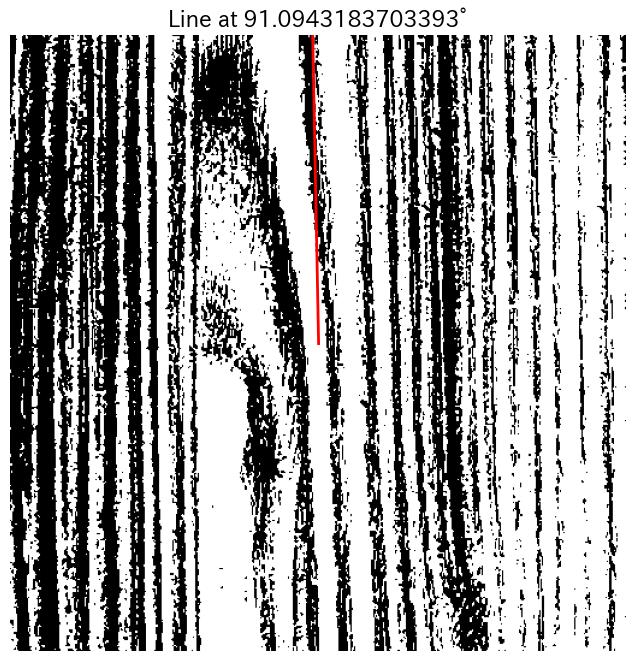

In [11]:
# 画像の読み込み
image_path = "../Plot/切り取り2値化画像.png"  # 画像パスを指定してください
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # グレースケールで読み込み

# 線の長さを設定
line_length = min(image.shape[1], image.shape[0]) // 2  # 画像の短辺の半分

# 画像の中心を計算
height, width = image.shape
center_x, center_y = width // 2, height // 2  # 中心座標

# 配向角をラジアンに変換
angle_deg = rotation_angle
angle_rad = np.deg2rad(angle_deg)

# 線の終点を計算
end_x = center_x + line_length * np.cos(angle_rad)
end_y = center_y - line_length * np.sin(angle_rad)  # Y座標は上下反転

# matplotlibで画像に線を描画
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray')  # グレースケール画像を表示
plt.axis('off')  # 軸を非表示

# 線を描画（始点から終点）
plt.plot([center_x, end_x], [center_y, end_y], color='red', linewidth=2)  # 赤い線を描画

# タイトルと表示
plt.title(f'Line at {rotation_angle}°', fontsize=16)
plt.show()